# DETERMINAR A COLHEIRA DE 2020


### IMPORTAR BIBLIOTECAS NECESSARIAS


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

### CARREGAR OS DADOS 

Para carregar os dados utilizarei a biblioteca Pandas pois os dados estão no formato ".csv"

In [2]:
safra18_19 = pd.read_csv('Safra_2018-2019.csv', index_col=0)
safra18_19.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,SCROP00005,342,1,0,1,0,0.0,0,2,1


In [3]:
safra20 = pd.read_csv('Safra_2020.csv', index_col=0)
safra20.head()

,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
80000,SCROP80001,256,0,1,2,35,11.0,9,1
80001,SCROP80002,283,0,1,2,5,5.0,6,1
80002,SCROP80003,283,0,1,2,15,15.0,5,2
80003,SCROP80004,283,0,1,2,15,NaN,7,2
80004,SCROP80005,283,0,1,2,15,19.0,2,1


## ANALIZES DOS DADOS 

Para entender um pouco mais sobre os dados e como eles se distribuem vou fazer algumas análises estatísticas simples


### TRATAMENTO DOS DADOS 

#### index

Como o Identificador_Agricultor pode poluir meus dados vou defini-lo como index caso não haja valores repetidos 

In [4]:
print(any(safra18_19['Identificador_Agricultor'].duplicated()))
print(any(safra20['Identificador_Agricultor'].duplicated()))

False
False


In [5]:
safra18_19 = safra18_19.set_index('Identificador_Agricultor')
safra20 = safra20.set_index('Identificador_Agricultor')

#### OBSERVANDO O FORMATO 

In [6]:
numLinhas, numColunas = safra18_19.shape
print("Linhas: {} \nColunas: {}".format(numLinhas, numColunas))
print(safra18_19 ['dano_na_plantacao'].unique())
print(type(safra18_19))
safra18_19.head()

Linhas: 80000 
Colunas: 9
[0 1 2]
<class 'pandas.core.frame.DataFrame'>


,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
Identificador_Agricultor,,,,,,,,,
SCROP00001,188,1,0,1,0,0.0,0,1,0
SCROP00002,209,1,0,1,0,0.0,0,2,1
SCROP00003,257,1,0,1,0,0.0,0,2,1
SCROP00004,257,1,1,1,0,0.0,0,2,1
SCROP00005,342,1,0,1,0,0.0,0,2,1


Temos um Data Frame com 10 colunas(contando com o ID do Agricultor, colocado como indice), 80 000 Linhas e as 3 respostas esperadas estão presentes 

#### VERIFICAR E REMOVER NaNs

In [7]:
NA=safra18_19.isna().any()
NA

Estimativa_de_Insetos    False
Tipo_de_Cultivo          False
Tipo_de_Solo             False
Categoria_Pesticida      False
Doses_Semana             False
Semanas_Utilizando        True
Semanas_Sem_Uso          False
Temporada                False
dano_na_plantacao        False
dtype: bool

ara decidir que ação tomar com os NaNs da categoria Semanas_Utilizando verificarei sua ocorrência em Categoria_Pesticida pois caso seja em sua maioria 1 (Nunca Usou) assumirei o valor 0 caso contrário o valor da mediana

In [8]:
NA_Semanas_Utilizando = safra18_19[safra18_19.Semanas_Utilizando.isna()]
NA_Semanas_Utilizando.Categoria_Pesticida.value_counts()

2    5776
3    2191
1      88
Name: Categoria_Pesticida, dtype: int64

In [9]:
safra18_19['Semanas_Utilizando'].fillna(safra18_19['Semanas_Utilizando'].median(), inplace=True)
print(safra18_19 ['Semanas_Utilizando'].unique())

[ 0. 28. 26. 20. 15. 14. 19. 24.  8. 23. 25. 29. 22. 21. 17. 30. 35. 32.
 27. 16. 31. 33. 34. 39. 38. 42. 40. 41. 36. 44. 37. 46. 45. 47. 43. 50.
 10. 49. 53. 48. 51. 54. 52. 55. 56. 61. 18. 57. 62. 60. 63. 66. 59. 64.
 13.  7.  5. 12.  6.  9. 58. 11. 65. 67.]


#### 2020

In [10]:
NA=safra20.isna().any()
NA

Estimativa_de_Insetos    False
Tipo_de_Cultivo          False
Tipo_de_Solo             False
Categoria_Pesticida      False
Doses_Semana             False
Semanas_Utilizando        True
Semanas_Sem_Uso          False
Temporada                False
dtype: bool

In [11]:
safra20['Semanas_Utilizando'].fillna(safra20['Semanas_Utilizando'].median(), inplace=True)
print(safra20 ['Semanas_Utilizando'].unique())

[11.  5. 15. 27. 19.  7. 12. 18. 16. 22. 20. 10. 17. 13. 21. 24. 23. 25.
 30. 28.  9. 14. 26. 31. 36. 29.  6. 35.  8. 32. 33. 39. 34. 38. 40. 37.
 43. 41. 45. 42. 44. 48. 51. 50. 46. 47. 49. 52. 53. 55.  0. 54. 56. 60.
 58. 63. 62. 64. 59. 61. 57. 67.]


### PLOTS

Para as variáveis quantitativas farei boxplots e para as qualitativas gráfico de barras.

##### Estimativa de Insetos

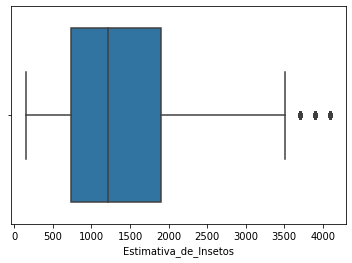

In [12]:
sns.boxplot(safra18_19.Estimativa_de_Insetos)

##### Tipo de Cultivo

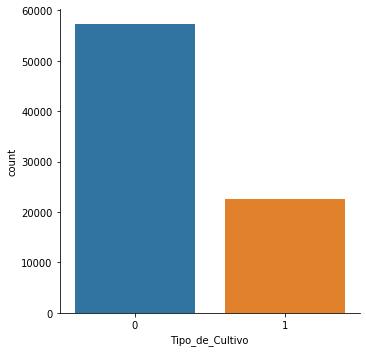

In [13]:
sns.catplot (x="Tipo_de_Cultivo", kind = 'count', data = safra18_19)

##### Tipo de Solo

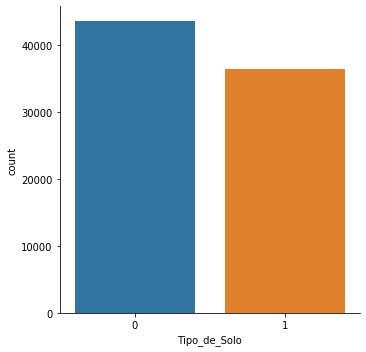

In [14]:
sns.catplot(x = "Tipo_de_Solo", kind ="count", data = safra18_19)

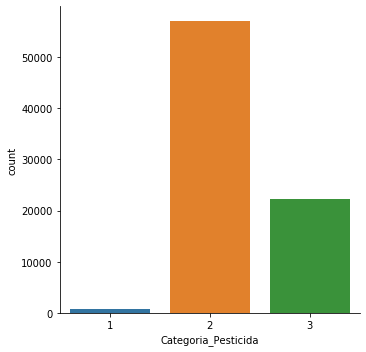

In [15]:
sns.catplot(x = "Categoria_Pesticida", kind ="count", data = safra18_19)

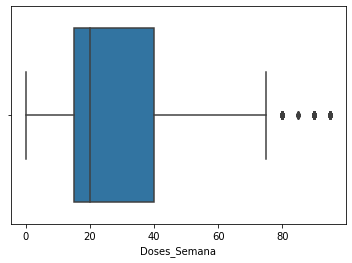

In [16]:
sns.boxplot(safra18_19.Doses_Semana)

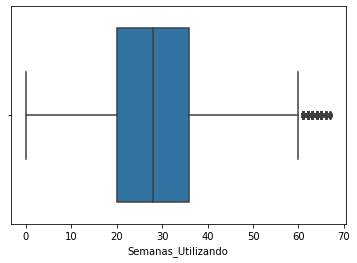

In [17]:
sns.boxplot(safra18_19.Semanas_Utilizando)

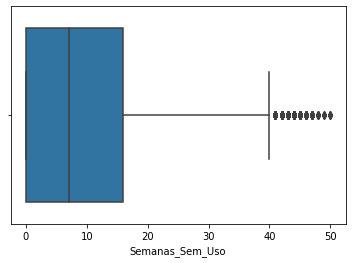

In [18]:
sns.boxplot(safra18_19.Semanas_Sem_Uso)

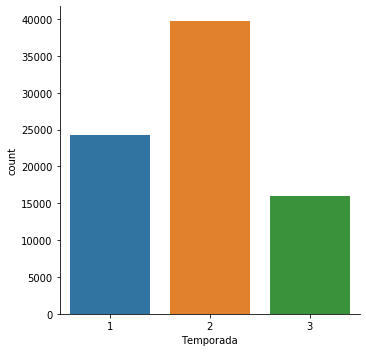

In [19]:
sns.catplot(x='Temporada', kind ='count', data=safra18_19)

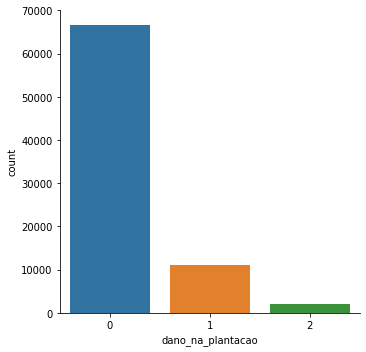

In [20]:
sns.catplot(x='dano_na_plantacao', kind ='count', data=safra18_19)

In [21]:
safra18_19.corr()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
Estimativa_de_Insetos,1.000000,-0.090063,-0.056147,-0.080734,-0.101807,0.414125,0.298849,0.002964,0.203290
Tipo_de_Cultivo,-0.090063,1.000000,-0.278775,0.238823,-0.190884,-0.042741,-0.235928,0.002792,-0.017228
Tipo_de_Solo,-0.056147,-0.278775,1.000000,0.035994,0.076580,-0.064807,0.006122,0.002066,-0.021176
Categoria_Pesticida,-0.080734,0.238823,0.035994,1.000000,-0.002913,0.326165,-0.556253,0.001175,0.172943
Doses_Semana,-0.101807,-0.190884,0.076580,-0.002913,1.000000,0.117444,-0.034144,-0.002251,-0.030476
Semanas_Utilizando,0.414125,-0.042741,-0.064807,0.326165,0.117444,1.000000,-0.424593,0.001812,0.221034
Semanas_Sem_Uso,0.298849,-0.235928,0.006122,-0.556253,-0.034144,-0.424593,1.000000,0.003220,-0.133115
Temporada,0.002964,0.002792,0.002066,0.001175,-0.002251,0.001812,0.003220,1.000000,-0.002233
dano_na_plantacao,0.203290,-0.017228,-0.021176,0.172943,-0.030476,0.221034,-0.133115,-0.002233,1.000000


Para as variáveis quantitativas com não há correlações altas normalmente se separaria a categoria Semanas_Sem_Uso em intervalos na tentativa de obter mais correlações, porem isso diminuiu a precisão da minha predição consideravelmente 

### TRANSFORMAR AS VARIAVEIS CATEGORICAS EM BINARIAS - One Hot Encoding

para que se consiga extrair mais informações e como as variáveis são qualitativas nominais dividirei em colunas binarias (One Hot Encoding) com a função get_dummies do pandas


##### CATEGORIA PESTICIDA

In [22]:
one_hot = pd.get_dummies(safra18_19.Categoria_Pesticida, prefix='Categoria_Pesticida_')
safra = safra18_19.drop('Categoria_Pesticida', axis = 1)
safra = pd.concat([safra, one_hot], axis=1)
safra

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao,Categoria_Pesticida__1,Categoria_Pesticida__2,Categoria_Pesticida__3
Identificador_Agricultor,,,,,,,,,,,
SCROP00001,188,1,0,0,0.0,0,1,0,1,0,0
SCROP00002,209,1,0,0,0.0,0,2,1,1,0,0
SCROP00003,257,1,0,0,0.0,0,2,1,1,0,0
SCROP00004,257,1,1,0,0.0,0,2,1,1,0,0
SCROP00005,342,1,0,0,0.0,0,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
SCROP79996,209,0,1,20,12.0,6,2,0,0,1,0
SCROP79997,232,0,1,20,12.0,9,1,0,0,1,0
SCROP79998,256,0,1,10,14.0,10,1,0,0,1,0


##### TEMPORADA

In [23]:
one_hot = pd.get_dummies(safra18_19.Temporada, prefix='Temporada_')
safra = safra.drop('Temporada', axis = 1)
safra = pd.concat([safra, one_hot], axis=1)
safra

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,dano_na_plantacao,Categoria_Pesticida__1,Categoria_Pesticida__2,Categoria_Pesticida__3,Temporada__1,Temporada__2,Temporada__3
Identificador_Agricultor,,,,,,,,,,,,,
SCROP00001,188,1,0,0,0.0,0,0,1,0,0,1,0,0
SCROP00002,209,1,0,0,0.0,0,1,1,0,0,0,1,0
SCROP00003,257,1,0,0,0.0,0,1,1,0,0,0,1,0
SCROP00004,257,1,1,0,0.0,0,1,1,0,0,0,1,0
SCROP00005,342,1,0,0,0.0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCROP79996,209,0,1,20,12.0,6,0,0,1,0,0,1,0
SCROP79997,232,0,1,20,12.0,9,0,0,1,0,1,0,0
SCROP79998,256,0,1,10,14.0,10,0,0,1,0,1,0,0


In [24]:
safra.corr()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,dano_na_plantacao,Categoria_Pesticida__1,Categoria_Pesticida__2,Categoria_Pesticida__3,Temporada__1,Temporada__2,Temporada__3
Estimativa_de_Insetos,1.000000,-0.090063,-0.056147,-0.101807,0.414125,0.298849,0.203290,0.028452,0.070564,-0.077471,-0.003939,0.003078,0.000677
Tipo_de_Cultivo,-0.090063,1.000000,-0.278775,-0.190884,-0.042741,-0.235928,-0.017228,0.059311,-0.270415,0.260329,-0.001094,-0.001910,0.003641
Tipo_de_Solo,-0.056147,-0.278775,1.000000,0.076580,-0.064807,0.006122,-0.021176,0.010179,-0.041288,0.039505,0.000090,-0.003067,0.003726
Doses_Semana,-0.101807,-0.190884,0.076580,1.000000,0.117444,-0.034144,-0.030476,-0.163032,0.073070,-0.038421,0.001636,0.000153,-0.002069
Semanas_Utilizando,0.414125,-0.042741,-0.064807,0.117444,1.000000,-0.424593,0.221034,-0.211245,-0.243684,0.292074,-0.004097,0.004987,-0.001525
Semanas_Sem_Uso,0.298849,-0.235928,0.006122,-0.034144,-0.424593,1.000000,-0.133115,-0.094599,0.611117,-0.596887,-0.000541,-0.003526,0.005025
dano_na_plantacao,0.203290,-0.017228,-0.021176,-0.030476,0.221034,-0.133115,1.000000,0.186822,-0.257666,0.219758,-0.001271,0.005473,-0.005376
Categoria_Pesticida__1,0.028452,0.059311,0.010179,-0.163032,-0.211245,-0.094599,0.186822,1.000000,-0.154796,-0.060758,-0.001993,0.009027,-0.008985
Categoria_Pesticida__2,0.070564,-0.270415,-0.041288,0.073070,-0.243684,0.611117,-0.257666,-0.154796,1.000000,-0.976716,0.001004,-0.002459,0.001918
Categoria_Pesticida__3,-0.077471,0.260329,0.039505,-0.038421,0.292074,-0.596887,0.219758,-0.060758,-0.976716,1.000000,-0.000582,0.000524,0.000013


As únicas correlações são, as já esperadas, Categoria_Pesticida 2 e 3 devido a baixa freqüência de 1, Temporadas 1 e 2 e Categoria_Pesticida com Semanas_Sem_Uso. 

## SEPARANDO AS VARIAVEIS TESTE E DEFININDO PARAMETROS XGBOOST

#### separando as respostas

In [25]:
target = safra['dano_na_plantacao']
data = safra.drop(columns=['dano_na_plantacao'])

In [26]:
x_train, x_test,y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=11)

Através do train_test_split temos 75% dos dados separados para treinar o modelo e 25% para valida-lo 

#### DEFININDO PARAMETROS PARA O XGBOOST

In [27]:
params = {
    'max_depth': 6, 
    'learning_rate': 0.3,
    'objective': 'multi:softmax',
    'num_class': 3
}


Parâmetros definidos: Quão profundo ele cai em uma árvore de decisão; Taxa de aprendizado, foi deixado baixo para evitar overfitting e por termos uma boa quantidade de dados; Classificação para múlti classes pois temos 3 classes 1- Nunca Usou, 2-Já Usou, 3-Esta usando; Número de classes

#### FUNCAO REPORT PARA OS MODELOS 


Função para imprimir valores de acurácia, precisão e F1 Score, facilitando a validação de cada modelo testado 

In [28]:
def gen_report(y, y_pred):
    print("Acurácia = ", accuracy_score(y, y_pred))
    print("Precisão = ", precision_score(y, y_pred, average = 'weighted', zero_division=0))
    print("Recall = ", recall_score(y, y_pred, average = 'weighted'))
    print("F1 Score = ", f1_score(y, y_pred, average = 'weighted'))

## XGBOOST

##### Rodando o XGBoost

In [29]:
model =xgb.XGBClassifier(params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Através do relatório gerado acima e da importância de cada coluna printada abaixo é que foram tomadas as decisões de tratamento dos dados e dos parâmetros

In [30]:
model.feature_importances_

array([0.0591358 , 0.05541199, 0.02327682, 0.0620041 , 0.04884704,
       0.02539585, 0.        , 0.6448816 , 0.01901543, 0.0205377 ,
       0.02013015, 0.02136353], dtype=float32)

##### TESTANDO O MODELO

In [31]:
predict = model.predict(x_test)

In [32]:
gen_report(y_test, predict)

Acurácia =  0.84365
Precisão =  0.8020570506297721
Recall =  0.84365
F1 Score =  0.8058736996398557


In [33]:
pd.DataFrame.from_records(confusion_matrix(y_test, predict, labels=[0, 1, 2]))

,0,1,2
0,16270,363,4
1,2226,599,3
2,353,178,4


(hipótese) Através desta tabela podemos deduzir que a alta quantidade da resposta 0 desloca o aprendizado para esta resposta e se os dados fossem mais equilibrados o resultado seria diferente

## TESTE EM LOGISTIC REGRESSION

Para tirar a prova real fiz o teste em outra função de predição de facil uso

In [34]:
clf = LogisticRegression(max_iter=100000, multi_class='multinomial').fit(x_train, y_train)

Função também ajustada para múlti classes e com número máximo de 1mi de interações devido o grande volume de dados 

In [35]:
y_Test_Pred = clf.predict(x_test)


In [36]:
gen_report(y_test, y_Test_Pred)

Acurácia =  0.8354
Precisão =  0.773431526376921
Recall =  0.8354
F1 Score =  0.7842692529999503


In [37]:
pd.DataFrame.from_records(confusion_matrix(y_test, y_Test_Pred, labels=[0, 1, 2]))

,0,1,2
0,16381,256,0
1,2501,327,0
2,440,95,0


Os resultados foram ainda piores com a resposta 2 nem mesmo sendo escolhida, mostrando maior eficiência do XGBoost.

## Rodar novamente utilizando Under-sampling

O Under-sampling consiste em diminuir a quantidade dos outros dados para não deslocar a decisão para o lado com o maior número de respostas oferecendo uma representação mais equilibrada nos clusters. Aplicando esta técnica esperamos que a precisão aumente 

Observando a frequência de cada resposta

In [38]:
safra.dano_na_plantacao.value_counts()

0    66716
1    11183
2     2101
Name: dano_na_plantacao, dtype: int64

Armazenando o menor valor

In [39]:
menor_len = len(safra[safra['dano_na_plantacao']==2])
menor_len

2101

Armazenando os índices

In [40]:
class_2_indices = safra[safra['dano_na_plantacao']==2].index
class_1_indices = safra[safra['dano_na_plantacao']==1].index
class_0_indices = safra[safra['dano_na_plantacao']==0].index

Pegando a mesma qauntidade de indices de forma aleatoria 

In [41]:
random_1_indices = np.random.choice(class_1_indices, menor_len, replace=False)
random_0_indices = np.random.choice(class_0_indices, menor_len, replace=False)
print(len(random_1_indices))

2101


Juntando todos os índices

In [42]:
sample_indices = np.concatenate([class_2_indices, random_1_indices, random_0_indices])

Montando o dataset com as respostas equilibradas

In [43]:
sample = safra.loc[sample_indices]
sample.dano_na_plantacao.value_counts()

2    2101
1    2101
0    2101
Name: dano_na_plantacao, dtype: int64

#### separando as respostas do novo dataset

In [44]:
Y=sample['dano_na_plantacao']
X=sample.drop(columns=['dano_na_plantacao'])

In [45]:
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)

Novamente 25% para validação do modelo 

### TESTANDO MODELO COM UNDER SAMPLE

In [46]:
model_US = xgb.XGBClassifier(params)
model_US.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
model_US.feature_importances_

array([0.04030989, 0.03304008, 0.02605064, 0.03987377, 0.03564219,
       0.03303764, 0.        , 0.68887794, 0.01783149, 0.02936131,
       0.02624853, 0.02972649], dtype=float32)

Se mostra muito similar ao modelo sem under sampling

In [48]:
predict_US = model.predict(X_test)
gen_report(Y_test, predict_US)

Acurácia =  0.4251269035532995
Precisão =  0.5599443403176267
Recall =  0.4251269035532995
F1 Score =  0.3189156235123441


Apesar da baixa eficiência nos dados de teste, vamos ver como ele prevê os dados sem under sampling

In [49]:
predict_US_all = model.predict(x_test)
gen_report(y_test, predict_US_all)

Acurácia =  0.84365
Precisão =  0.8020570506297721
Recall =  0.84365
F1 Score =  0.8058736996398557


In [50]:
pd.DataFrame.from_records(confusion_matrix(y_test, predict_US_all, labels=[0, 1, 2]))

,0,1,2
0,16270,363,4
1,2226,599,3
2,353,178,4


#### CONCLUSÃO

Mesmo com o under sampling o resultado foi exatamente o mesmo, mostrando que os dados, da maneira que estão dispostos, convergem para a resposta "0" sendo, portanto, necessário tratamento nos dados que não foram testados ou outra abordagem como, por exemplo, visualizar de forma binaria se houve ou não danos na plantação e depois se o dano foi por pesticidas ou por outros motivos.

## GERAR RESPOSTA

### TRATAR OS DADOS PARA QUE FIQUEM IGUAIS AOS DE 2018 E 2019

##### CATEGORIA PESTICIDA

In [51]:
one_hot = pd.get_dummies(safra20.Categoria_Pesticida, prefix='Categoria_Pesticida_')
safra20 = safra20.drop('Categoria_Pesticida', axis = 1)
safra20 = pd.concat([safra20, one_hot], axis=1)
safra20

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,Categoria_Pesticida__1,Categoria_Pesticida__2,Categoria_Pesticida__3
Identificador_Agricultor,,,,,,,,,,
SCROP80001,256,0,1,35,11.0,9,1,0,1,0
SCROP80002,283,0,1,5,5.0,6,1,0,1,0
SCROP80003,283,0,1,15,15.0,5,2,0,1,0
SCROP80004,283,0,1,15,27.0,7,2,0,1,0
SCROP80005,283,0,1,15,19.0,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
SCROP88854,3337,1,0,10,12.0,44,3,0,1,0
SCROP88855,3516,1,0,10,20.0,38,1,0,1,0
SCROP88856,3516,1,0,15,40.0,8,2,0,1,0


##### TEMPORADA

In [52]:
one_hot = pd.get_dummies(safra20.Temporada, prefix='Temporada_')
safra20 = safra20.drop('Temporada', axis = 1)
safra20 = pd.concat([safra20, one_hot], axis=1)
safra20

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Categoria_Pesticida__1,Categoria_Pesticida__2,Categoria_Pesticida__3,Temporada__1,Temporada__2,Temporada__3
Identificador_Agricultor,,,,,,,,,,,,
SCROP80001,256,0,1,35,11.0,9,0,1,0,1,0,0
SCROP80002,283,0,1,5,5.0,6,0,1,0,1,0,0
SCROP80003,283,0,1,15,15.0,5,0,1,0,0,1,0
SCROP80004,283,0,1,15,27.0,7,0,1,0,0,1,0
SCROP80005,283,0,1,15,19.0,2,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
SCROP88854,3337,1,0,10,12.0,44,0,1,0,0,0,1
SCROP88855,3516,1,0,10,20.0,38,0,1,0,1,0,0
SCROP88856,3516,1,0,15,40.0,8,0,1,0,0,1,0


Colocando os dados no modelo

In [53]:
resposta = model.predict(safra20)



#### colocando a coluna resposta no dataframe

In [54]:
resposta_final= safra20
resposta_final['dano_na_plantacao']=resposta

checando se há alguma resposta "2"

In [55]:
resposta_final.dano_na_plantacao.value_counts()

0    8416
1     436
2       6
Name: dano_na_plantacao, dtype: int64

exportando a resposta em .csv

In [56]:
resposta_final.to_csv("Safra_2020-resposta.csv")